In [3]:
import sys
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/gdrive')
    %cd gdrive/MyDrive/
    !git clone https://github.com/AfoninAndrei/OPT-ML.git
    %cd OPT-ML    
    sys.path.append('/content/gdrive/MyDrive/LastFM/src')
else:
    sys.path.append('src')

In [55]:
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns 

from training import *
from meta_optimizer import *
from optimizee import *
from loss import *

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

sns.set(color_codes=True)
sns.set_style("white")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a id=content><a>
## Content
1. ### [Number of parameters](#param)
2. ### [Quadratic function](#quad)
3. ### [MNIST](#mnist)
    * #### [Sigmoid activation](#sigm)
    * #### [Transferring to ReLU activation](#relu)


# Introduction

This work is trying to replace the optimizers normally used for neural networks (eg Adam, RMSprop, SGD etc.) by a hamiltonian neural networks. The idea is based on [Dissipative SymODEN](https://arxiv.org/pdf/2002.08860.pdf) and [Learning to learn by gradient descent by gradient descent](https://arxiv.org/pdf/1606.04474.pdf). The latter has the same goal but the approach is based on LSTM. In this project, we compare the model from this paper as well as normal optimizers widely-used in deep learning applications. Our implementation is based on [this GitHub repository](https://github.com/chenwydj/learning-to-learn-by-gradient-descent-by-gradient-descent).

 

In fact, gradient descent is fundamentally a **sequence** of updates (from the output layer of the neural net back to the input), in between which a **state** must be stored. Thus we can think of an optimizer as a ODE-Net (or RNN).
The loss of the optimizer is the sum (weights are set to 1 in our experiments) of the losses of the optimizee as it learns. 
$$\mathcal{L}(\phi) = \mathbb{E}_f \left[ \sum_{t=1}^T w_t f(\theta_t) \right]$$
where
$$\theta_{t+1} = \theta_t + g_t$$
$$\begin{bmatrix} g_t \\ h_{t+1} \end{bmatrix} = m(\nabla_t, h_t, \phi)$$

$f$ is the *optimizee* function, and $\theta_t$ is its parameters at time $t$.
$m$ is the *optimizer* function, $\phi$ is its parameters. $h_t$ is its state at time $t$. $g_t$ is the update it outputs at time $t$.

The plan is thus to use gradient descent on $\phi$ in order to minimize $\mathcal{L}(\phi)$, which should give us an optimizer that is capable of optimizing $f$ efficiently.

As the [paper](https://arxiv.org/pdf/1606.04474.pdf) mentions, it is important that the gradients in dashed lines in the figure below are **not** propagated during gradient descent.

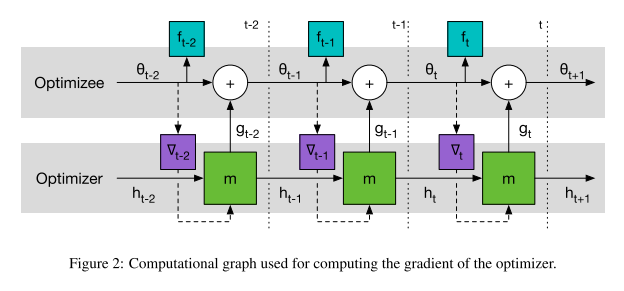

Basically this is nothing we wouldn't expect: the loss of the optimizer neural net is simply the average training loss of the optimizee as it is trained by the optimizer. The optimizer takes in the gradient of the current coordinate of the optimizee as well as its previous state, and outputs a suggested update that we hope will reduce the optimizee's loss as fast as possible.

Optimization is done coordinatewise such that to optimize each parameter by its own state. Any momentum or energy term used in the optimization is based on each parameter's own history, independent on others. Each parameter's optimization state is not shared across other coordinates.
The precondition assumed, is that all parameters share the same weights in a model-based optimizer.

As we perform operations, Pytorch builds the computational graph of the operations we perform. However, there are some variables that we want to detach from the graph at various points, specifically we want to pretend that the gradients are inputs (as specified in the previous image) that come from nowhere, instead of coming from the rest of the computational graph as they really do: this means we want to **detach** the gradients from the graph. Likewise, when every 15 or 20 steps we perform backpropagation on the optimizer network, we want the current hidden states and cell states, as well as the parameters of the optimizee to "forget" that they are dependent on previous steps in the graph. For all of this, a function called `detach_var` is used which creates a new Variable from the current variable's data, and makes sure that its gradients are still kept. This is different from the `.detach()` function in Pytorch which does not quite forget the original graph and also does not guarantee that the gradients will be there.

<a id=param><a>
# Compute number of parameters
[Back to content](#content)
    
Let's check how many parameter contain our models. It is seen that the proposed HNN model has much fewer parameters.

In [66]:
num_lstm_params = sum(p.numel() for p in Optimizer_LSTM().parameters())
num_hnn_params = sum(p.numel() for p in Optimizer_HNN().parameters())
print('Number of LSTM parameters: {}\nNumber HNN parameters: {}'.format(num_lstm_params, num_hnn_params))

Number of LSTM parameters: 5221
Number HNN parameters: 19


In [67]:
num_lstm_params = sum(p.numel() for p in Optimizer_LSTM(preproc=True).parameters())
num_hnn_params = sum(p.numel() for p in Optimizer_HNN(preproc=True).parameters())
print('Number of LSTM parameters: {}\nNumber HNN parameters: {}'.format(num_lstm_params, num_hnn_params))

Number of LSTM parameters: 5301
Number HNN parameters: 55


<a id=quad><a>
# Quadratic function
[Back to content](#content)

These are pretty simple: our optimizer is supposed to find a 10-element vector called $\theta$ that, when multiplied by a 10x10 matrix called $W$, is as close as possible to a 10-element vector called $y$. Both $y$ and $W$ are generated randomly from the normal distibution. The error is simply the squared error.

Find the best learning rate for the optimizer of our model and "learning rate" of output gradients which is called **out_mul**. The training is going for 20 epochs for one combination of parameters. Then, it is re-trained for 100 epochs. The parameters that are used for LSTM and normal optimizers are taken from [the implementation](https://github.com/chenwydj/learning-to-learn-by-gradient-descent-by-gradient-descent) which replicates the original paper.

In [40]:
best_loss, best_lr, best_out_mul = find_best_parameters_HNN(QuadraticLoss, QuadOptimizee)
print(best_loss, best_lr, best_out_mul)

0.53969946 0.01 0.001


Train HNN to produce better gradients on the quadratic function. The optimizer is trained every 15 epochs.

In [13]:
loss_HNN, quad_optimizer_HNN = fit(QuadraticLoss, QuadOptimizee, 'HNN', unroll=15, optim_it=100, lr=0.01,\
                                       n_tests=50, n_epochs=100, out_mul=0.001)

Train LSTM to produce better gradients on the quadratic function. The optimizer is trained every 20 epochs.

In [14]:
loss_LSTM, quad_optimizer_LSTM = fit(QuadraticLoss, QuadOptimizee, 'LSTM', unroll=20, optim_it=100, lr=0.003,\
                                          n_tests=50, n_epochs=100)

In [15]:
print('Best loss of LSTM = ', loss_LSTM)
print('Best loss of HNN = ', loss_HNN)

Best loss of LSTM =  0.35714084
Best loss of HNN =  0.48392123


The final evaluation where the parameter of model-based optimizers are not touched, i.e. we use them as normal optimizers. We run the training 100 times to make sure that the methods permanently achieves demonstrated results.

In [22]:
fit_data = np.zeros((100, 100, 6))

opt = w(Optimizer_LSTM())
opt.load_state_dict(quad_optimizer_LSTM)
fit_data[:, :, 0] = np.array([one_step_fit_LSTM(opt, None, QuadraticLoss, QuadOptimizee, \
                                                1, 100, 100, out_mul=1.0, should_train=False) for _ in range(100)])
opt = w(Optimizer_HNN())
opt.load_state_dict(quad_optimizer_HNN)
fit_data[:, :, 1] = np.array([one_step_fit_HNN(opt, None, QuadraticLoss, QuadOptimizee, \
                                               1, 100, 100, out_mul=0.001, should_train=False) for _ in range(100)])
QUAD_LRS = [0.1, 0.03, 0.01, 0.01]
NORMAL_OPTS = [(optim.Adam, {}), (optim.RMSprop, {}), (optim.SGD, {'momentum': 0.9}), (optim.SGD, {'nesterov': True, 'momentum': 0.9})]
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    fit_data[:, :, 2 + i] = np.array(fit_normal(QuadraticLoss, QuadOptimizeeNormal, opt, lr=lr, **extra_kwargs))

In [45]:
np.save('quad_fit_data', fit_data)

In [63]:
names = ['LSTM', 'HNN', 'ADAM', 'RMSprop', 'SGD', 'NAG']
for i, name in enumerate(names):
    print('{}: {:.2f}'.format(name, np.mean(fit_data, axis=0)[-1, i]))

LSTM: 0.25
HNN: 0.23
ADAM: 0.41
RMSprop: 0.76
SGD: 0.33
NAG: 0.45


Finally, we plot the learning curve for HNN, LSTM and normal optimizers in log-scale for y-axis.

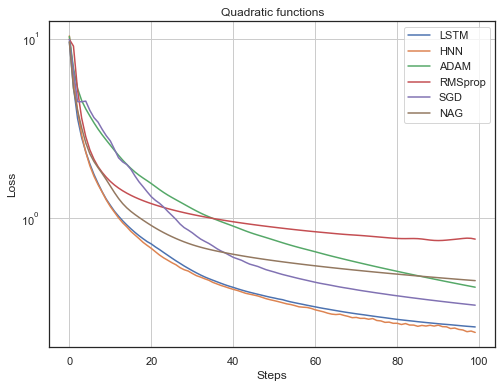

In [65]:
plt.figure(figsize=(8,6))
for i, opt in enumerate(names):
    plt.plot(np.mean(fit_data[:,:,i], axis=0), label=opt)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Quadratic functions')
plt.legend()
plt.grid()
plt.savefig('quad.pdf')
plt.show()

<a id=mnist><a>
# MNIST
[Back to content](#content)
    
Now, we move on to MNIST. We just need to re-implement the optimizee and "loss" function. Namely, optimizee contains a single hidden layer with 20 hidden units network. We make it easy to change the activation function to some other activation. Because, we want to verify how our model-based optimizers can be transferred to traininig the neural network with another activation function. Specifically, we train our model-based optimizers with a sigmoid and evaluate their performance on both sigmoid and relu activations. Our results show that the proposed method with HNN is more robust to changes of activation functions.

Again, we look for better hyper-parameters for HNN and use default ones for other model-based optimizers.

In [ ]:
best_loss, best_lr, best_out_mul=find_best_parameters_HNN(MNISTLoss, create_MNISTNet(nn.Sigmoid()), preproc=True)
print(best_loss, best_lr, best_out_mul)

Train model-based optimizers. Here, we use only 50 epochs since the task is more computationally-intensive.

In [36]:
loss_HNN, MNIST_optimizer_HNN = fit(MNISTLoss, create_MNISTNet(nn.Sigmoid()), 'HNN', unroll=15, optim_it=100, lr=0.01,\
                                        out_mul=0.01, preproc=True, n_tests=20, n_epochs=50)

In [37]:
loss_LSTM, MNIST_optimizer_LSTM = fit(MNISTLoss, create_MNISTNet(nn.Sigmoid()), 'LSTM', unroll=20, optim_it=100, lr=0.01,\
                                           out_mul=0.1, preproc=True, n_tests=20, n_epochs=50)

In [44]:
print('Best loss of LSTM = ', loss_LSTM)
print('Best loss of HNN = ', loss_HNN)

Best loss of LSTM =  2.3028798
Best loss of HNN =  0.6140237


<a id=sigm><a>
### Sigmoid activation (the same as for the training)
[Back to content](#content)

Train optimizees by trained optimizers

In [48]:
fit_data = np.zeros((100, 100, 6))

opt = w(Optimizer_LSTM(preproc=True))
opt.load_state_dict(MNIST_optimizer_LSTM)
fit_data[:, :, 0] = np.array([one_step_fit_LSTM(opt, None, MNISTLoss, create_MNISTNet(nn.Sigmoid()), 1, 100, 200, out_mul=1.0, should_train=False) for _ in range(100)])
opt = w(Optimizer_HNN(preproc=True))
opt.load_state_dict(MNIST_optimizer_HNN)
fit_data[:, :, 1] = np.array([one_step_fit_HNN(opt, None, MNISTLoss, create_MNISTNet(nn.Sigmoid()), 1, 100, 200, out_mul=0.001, should_train=False) for _ in range(100)])
QUAD_LRS = [0.03, 0.01, 1.0, 1.0]
NORMAL_OPTS = [(optim.Adam, {}), (optim.RMSprop, {}), (optim.SGD, {'momentum': 0.9}), (optim.SGD, {'nesterov': True, 'momentum': 0.9})]
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    fit_data[:, :, 2 + i] = np.array(fit_normal(MNISTLoss, MNISTNet, opt, lr=lr, **extra_kwargs))

In [53]:
np.save('mnist_fit_data_relu', fit_data)

In [50]:
names = ['LSTM', 'HNN', 'ADAM', 'RMSprop', 'SGD', 'NAG']
for i, name in enumerate(names):
    print('{}: {:.2f}'.format(name, np.mean(fit_data, axis=0)[-1, i]))

LSTM: 2.31
HNN: 0.41
ADAM: 0.35
RMSprop: 0.38
SGD: 0.44
NAG: 0.36


Plot the learning curves of all (meta-)optimizers.

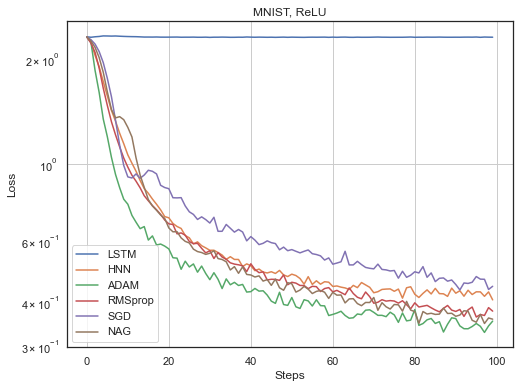

In [52]:
plt.figure(figsize=(8,6))
for i, opt in enumerate(names):
    plt.plot(np.mean(fit_data[:,:,i], axis=0), label=opt)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('MNIST, Sigmoid')
plt.legend()
plt.yscale('log')
plt.grid()
plt.savefig('mnist_sigmoid.pdf')
plt.show()

<a id=relu><a>
### Transferring to ReLU activation (differs from the training)
[Back to content](#content)

Now, we exploit already trained on the model with the sigmoid actiovation optimizers and explore how the results are changed if we replace the sigmoid activation with the ReLU one. It is seen that our HNN-based optimizer is not affected of this change while the LSTM-based got stuck. 

In [48]:
fit_data = np.zeros((100, 100, 6))

opt = w(Optimizer_LSTM(preproc=True))
opt.load_state_dict(MNIST_optimizer_LSTM)
fit_data[:, :, 0] = np.array([one_step_fit_LSTM(opt, None, MNISTLoss, create_MNISTNet(nn.ReLU()), 1, 100, 200, out_mul=1.0, should_train=False) for _ in range(100)])
opt = w(Optimizer_HNN(preproc=True))
opt.load_state_dict(MNIST_optimizer_HNN)
fit_data[:, :, 1] = np.array([one_step_fit_HNN(opt, None, MNISTLoss, create_MNISTNet(nn.ReLU()), 1, 100, 200, out_mul=0.001, should_train=False) for _ in range(100)])
QUAD_LRS = [0.03, 0.003, 0.3, 0.3]
NORMAL_OPTS = [(optim.Adam, {}), (optim.RMSprop, {}), (optim.SGD, {'momentum': 0.9}), (optim.SGD, {'nesterov': True, 'momentum': 0.9})]
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    fit_data[:, :, 2 + i] = np.array(fit_normal(MNISTLoss, MNISTNet, opt, lr=lr, **extra_kwargs))

In [53]:
np.save('mnist_fit_data_relu', fit_data)

In [50]:
names = ['LSTM', 'HNN', 'ADAM', 'RMSprop', 'SGD', 'NAG']
for i, name in enumerate(names):
    print('{}: {:.2f}'.format(name, np.mean(fit_data, axis=0)[-1, i]))

LSTM: 2.31
HNN: 0.41
ADAM: 0.35
RMSprop: 0.38
SGD: 0.44
NAG: 0.36


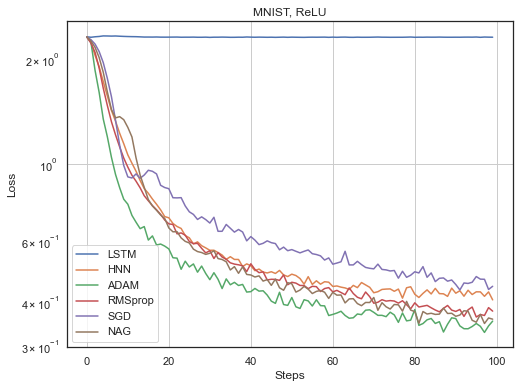

In [52]:
plt.figure(figsize=(8,6))
for i, opt in enumerate(names):
    plt.plot(np.mean(fit_data[:,:,i], axis=0), label=opt)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('MNIST, ReLU')
plt.legend()
plt.yscale('log')
plt.grid()
plt.savefig('mnist_relu.pdf')
plt.show()